# **EE5178: Panoramic Stitching**



# Brief Overview

In this problem set, you will implement panoramic stitching. Given two input images, we will "stitch" them together to create a simple panorama. To construct the image panorama, we will use concepts learned in class such as keypoint detection, local invariant descriptors, RANSAC, and perspective warping. 

The panoramic stitching algorithm consists of four main steps which we ask you to implement in individual functions:

1. Detect keypoints and extract local invariant descriptors from two input images. 

2. Match the descriptors between the two images.

3. Apply RANSAC to estimate a homography matrix between the extracted features.

4. Apply a perspective transformation using the homography matrix to merge image into a panorama.

Functions to implement (refer to function comments for more detail):

1. get_features

2. match_keypoints

3. find_homography and transform_ransac 

4. panoramic_stitching

# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [1]:
%matplotlib inline
import cv2 as cv
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# %%capture
# ! wget -O img1.jpg "https://drive.google.com/uc?export=download&id=1omMydL6ADxq_vW5gl_1EFhdzT9kaMhUt"
# ! wget -O img2.jpg "https://drive.google.com/uc?export=download&id=12lxB1ArAlwGn97XgBgt-SFyjE7udMGvf"

# Visualize Input Images

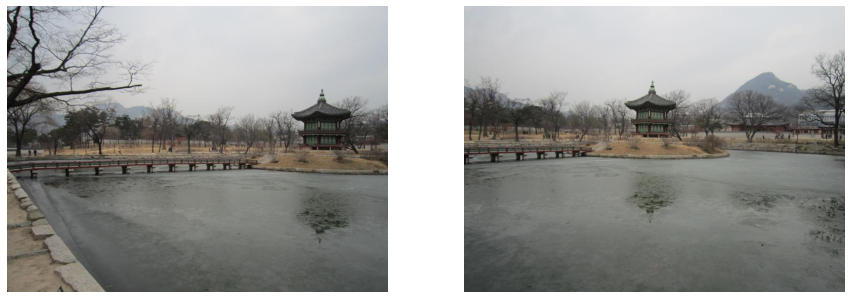

In [3]:
img1 = plt.imread('./data_n_2/img1.jpg')
img2 = plt.imread('./data_n_2/img2.jpg')

def plot_imgs(img1, img2):
    fig, ax = plt.subplots(1, 2, figsize=(15, 20))
    for a in ax:
        a.set_axis_off()
    ax[0].imshow(img1)
    ax[1].imshow(img2)

plot_imgs(img1, img2)

# Compute SURF/ SIFT/ ORB Features and Match Keypoints

In [4]:
def get_features(img):
    '''
    Compute SURF/SIFT/ORB features using cv2 library functions. Use default parameters when computing the keypoints.
    Input: 
      img: cv2 image
    Returns:
      keypoints: a list of cv2 keypoints
      descriptors: a list of feature descriptors
    '''
    sift = cv.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    keypoints, descriptors = sift.detectAndCompute(img,None)
    
    return keypoints, descriptors

def match_keypoints(desc_1, desc_2, ratio=0.75):
    '''
    You may use cv2 library functions.
    Input:
      desc_1, desc_2: list of feature descriptors
    Return:
      matches: list of feature matches
    '''
    
    # get the matches
    bf = cv.BFMatcher()
    matches = bf.knnMatch(desc_1, desc_2, k=2)
    
    # do ratio test
    good = []
    for m,n in matches:
        if m.distance < ratio*n.distance:
            good.append(m)
            
    return good

keypoints for img1 and img2


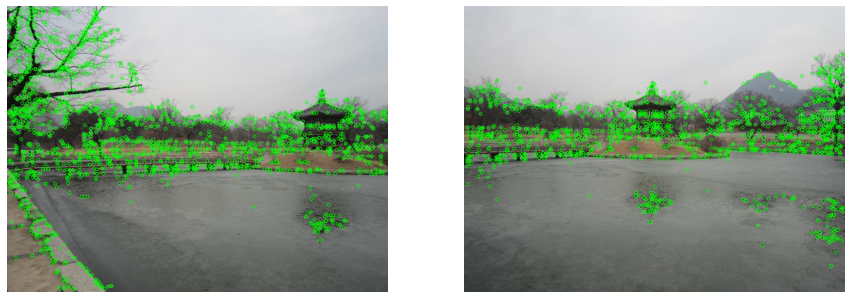

In [5]:
kp_1, desc_1 = get_features(img1)
kp_2, desc_2 = get_features(img2)

kp_img1 = cv.drawKeypoints(img1, kp_1, None, color=(0,255,0), flags=0)
kp_img2 = cv.drawKeypoints(img2, kp_2, None, color=(0,255,0), flags=0)

print('keypoints for img1 and img2')
plot_imgs(kp_img1, kp_img2)

feature matches


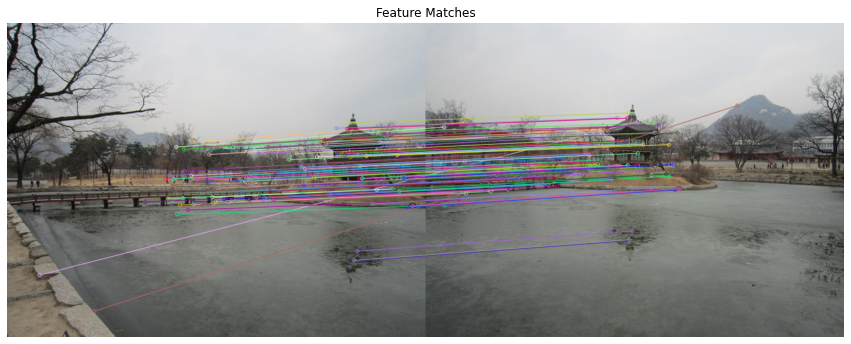

In [6]:
matches = match_keypoints(desc_1, desc_2, 0.75)
match_plot = cv.drawMatches(img1, kp_1, img2, kp_2, matches[::4], None, flags=2)
print("feature matches")
plt.figure(figsize = (15,10))
plt.title("Feature Matches")
plt.axis("off")
plt.imshow(match_plot)
plt.show()

# Compute Homography Matrix using RANSAC

In [7]:
def find_homography(pts_1, pts_2):
    '''
    Implement Direct Linear Transform to find a homography that estimates the transformation mapping from pts_1 to pts_2.
    e.g. If x is in pts_1 and y is in pts_2, then y = H * x
    Input:
      pts_1, pts_1: (N, 2) matrix 
    Return:
      H: the resultant homography matrix (3 x 3)
    '''
    
    A = []
    
    for i in range(len(pts_1)):
        x1, y1 = pts_1[i]
        x2, y2 = pts_2[i]
        
        A.append([x1, y1, 1, 0, 0, 0, -x2 * x1, -x2 * y1, -x2])
        A.append([0, 0, 0, x1, y1, 1, -y2 * x1, -y2 * y1, -y2])
        
    A = np.array(A)
    
    # Singular Value Decomposition (SVD)
    U, S, V = np.linalg.svd(A)
        
    # V[-1] is the eigenvector of (A^T)A with the smalles eigenvalue.
    # Reshape into 3x3 matrix.
    H = np.reshape(V[-1], (3, 3))

    # Normalization
    H = (1 / H.item(8)) * H
    
    return H

In [8]:
def dist(pt1, pt2, H):
    """ Returns the geometric distance between a pair of points given the
    homography H. """
    
    # points in homogeneous coordinates
    p1 = np.array([pt1[0], pt1[1], 1])
    p2 = np.array([pt2[0], pt2[1], 1])

    p2_estimate = np.dot(H, np.transpose(p1))
    p2_estimate = (1 / p2_estimate[2]) * p2_estimate
    
    return np.linalg.norm(np.transpose(p2) - p2_estimate)

In [9]:
def transform_ransac(pts_1, pts_2, thresh = 0.7, max_iter = 1000):
    '''
    Implement RANSAC to estimate homography matrix.
    Input:
      pts_1, pts_1: (N, 2) matrices
    Return:
      best_model: homography matrix with most inliers
    '''
    
    best_inliers = set()
    N = len(pts_1)
    
    for i in range(max_iter):
        idx = np.random.choice(N, 4, replace = False)
        pt1 = np.array([pts_1[j, :] for j in idx]).reshape((4,2))
        pt2 = np.array([pts_2[j, :] for j in idx]).reshape((4,2))
        
        H = find_homography(pt1, pt2)
        inliers = set()
        
        for j in range(N):
            if dist(pts_1[j], pts_2[j], H) < 10:
                inliers.add((pts_1[j][0], pts_1[j][1], pts_2[j][0], pts_2[j][1]))
                
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            if len(best_inliers) > (len(pts_1) * thresh): break
    
    pt1, pt2 = [], []
    for i in best_inliers:
        pt1.append((i[0], i[1]))
        pt2.append((i[2], i[3]))
    
    best_H = find_homography(pt1, pt2)
    best_model = (best_H, best_inliers)
    
    return best_model

[[ 1.82430695e+00  1.38013564e-03 -5.26879655e+02]
 [ 2.74735530e-01  1.59310921e+00 -1.91569128e+02]
 [ 1.01169296e-03  1.29827514e-04  1.00000000e+00]]


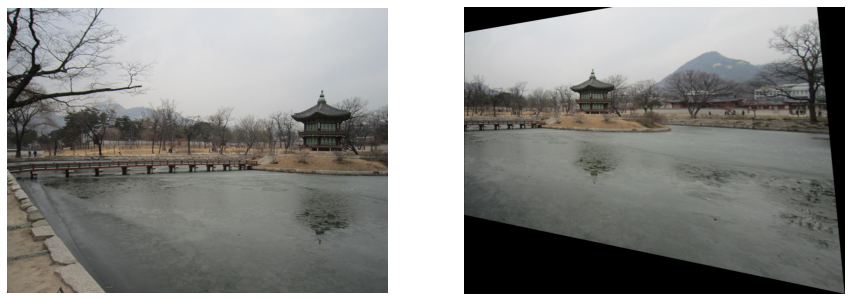

In [10]:
kp_1, desc_1 = get_features(img1)
kp_2, desc_2 = get_features(img2)
offset = 100

matches = match_keypoints(desc_1, desc_2, 0.75)

pts_1 = np.float32([kp_1[m.queryIdx].pt for m in matches]).reshape(-1,2)
pts_2 = np.float32([kp_2[m.trainIdx].pt for m in matches]).reshape(-1,2)

H, inliers = transform_ransac(pts_1, pts_2)
Hinv = np.linalg.inv(H)

height, width = 2000, 2000
result = cv.warpPerspective(img2, Hinv, (width, height))
print(H)

rows, cols = np.where(result[:, :, 0] != 0)
min_row, max_row = min(rows), max(rows) + 1
min_col, max_col = min(cols), max(cols) + 1
img2_trans = result[min_row:max_row, min_col:max_col, :]
plot_imgs(img1, img2_trans)

keypoints for img1 and img2_trans


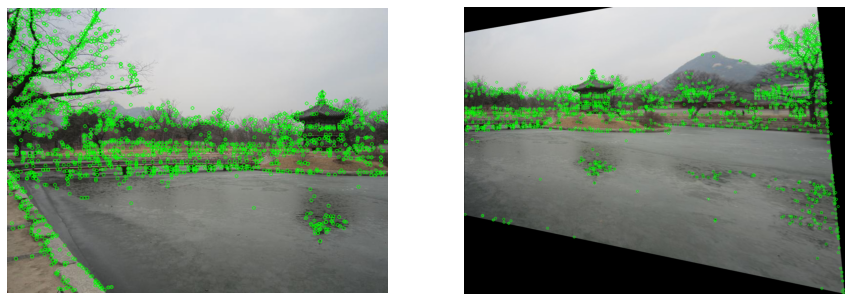

In [11]:
kp_1, desc_1 = get_features(img1)
kp_2_trans, desc_2_trans = get_features(img2_trans)

kp_img1 = cv.drawKeypoints(img1, kp_1, None, color=(0,255,0), flags=0)
kp_img2_trans = cv.drawKeypoints(img2_trans, kp_2_trans, None, color=(0,255,0), flags=0)

print('keypoints for img1 and img2_trans')
plot_imgs(kp_img1, kp_img2_trans) 

feature matches


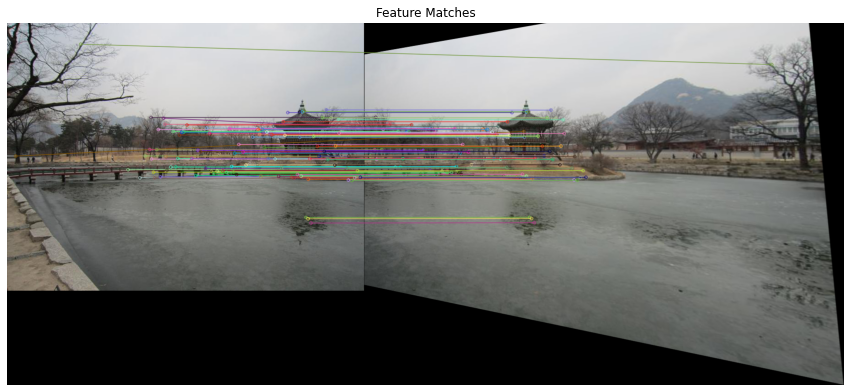

In [12]:
matches = match_keypoints(desc_1, desc_2_trans, 0.75)
match_plot = cv.drawMatches(img1, kp_1, img2_trans, kp_2_trans, matches[::4], None, flags=2)
print("feature matches")
plt.figure(figsize = (15,10))
plt.title("Feature Matches")
plt.axis("off")
plt.imshow(match_plot)
plt.show()

# Panoramic Stitching

In [13]:
def warpPerspective(img, H, dsize):
    h,w,c = img.shape
    Hinv = np.linalg.inv(H)
    mtr = np.zeros((w, h, c), dtype = np.int32)
    for i in range(img.shape[0]):
        mtr[:,i] = img[i]
        
    r, c = dsize
    out = np.zeros((r, c, mtr.shape[2]), dtype = np.int32)
    
    for i in range(r):
        for j in range(c):
            dst = np.dot(Hinv, [i,j,1])
            dst = dst/dst[-1]
            
            if dst[0] >= 0 and dst[0] < mtr.shape[0]:
                if dst[1] >= 0 and dst[1] < mtr.shape[1]:
                    out[i, j] = mtr[int(dst[0]), int(dst[1])]
        
    out_img = np.zeros((c, r, mtr.shape[2]), dtype=np.int32)
    for i in range(out.shape[0]):
        out_img[:,i] = out[i]
    return out_img

In [14]:
def trim(img):
    r, c = np.where(img[:, :, 0] != 0)
    trimmed = img[min(r): max(r)+1, min(c):max(c)+1, :]
    return trimmed

In [24]:
def panoramic_stitching(img1, img2):
    '''
    Generate a panoramic image using the obtained homography matrix.
    Input: 
      img1, img2: cv2 images
    Return:
      final_img: cv2 image of panorama
    '''

    kp_1, desc_1 = get_features(img1)
    kp_2, desc_2 = get_features(img2)
    offset = 100
    
    matches = match_keypoints(desc_1, desc_2, 0.75)
    
    pts_1 = np.float32([kp_1[m.queryIdx].pt for m in matches]).reshape(-1,2)
    pts_2 = np.float32([kp_2[m.trainIdx].pt for m in matches]).reshape(-1,2)
    
    H, inliers = transform_ransac(pts_1, pts_2)
    Hinv = np.linalg.inv(H)
    
    off = np.dot(Hinv, np.array([0,0,1]))
    off = off/off[-1]
    
    border = 200
    
    dst = np.dot(Hinv, np.array([img2.shape[1], img2.shape[0], 1]))
    dst = dst/dst[-1]
    
    dsize = (int(dst[0] + abs(off[0])), int(dst[1] + abs(off[1])))
    
    tmp = warpPerspective(img2, Hinv, dsize)
    tmp = cv.copyMakeBorder(tmp, border, border, border, border, cv.BORDER_CONSTANT, None, value = 0)

    for i in range(border, border + img1.shape[0]):
        for j in range(border, border + img1.shape[1]):
            try:
                if (tmp[i,j] == [0.,0.,0.]).all():
                    tmp[i,j] = img1[i-border, j-border]
                else: 
                    # merge the images in the overlapping areas
                    tmp[i,j] = (tmp[i,j]//2 + img1[i-border,j-border]//2)
            except:
                pass

    final = trim(tmp)
    return final

In [25]:
result = panoramic_stitching(img1, img2)

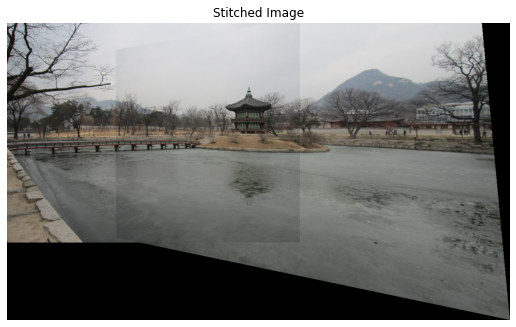

In [26]:
plt.figure(figsize = (9,9))
plt.title("Stitched Image")
plt.axis("off")
plt.imshow(result.astype('uint8'))
plt.savefig('./imgs/pan2')
plt.show()

# Three image Panorama

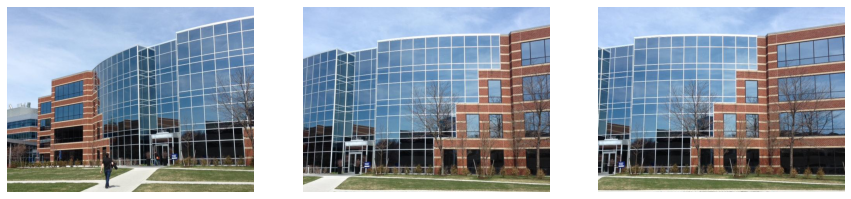

In [18]:
im1 = plt.imread('./data_n_3/image1.jpg')
im2 = plt.imread('./data_n_3/image2.jpg')
im3 = plt.imread('./data_n_3/image3.jpg')

def plot_3imgs(img1, img2, img3):
    fig, ax = plt.subplots(1, 3, figsize=(15, 20))
    for a in ax:
        a.set_axis_off()
    ax[0].imshow(img1)
    ax[1].imshow(img2)
    ax[2].imshow(img3)

plot_3imgs(im1, im2, im3)

keypoints for img1, img2 and img3


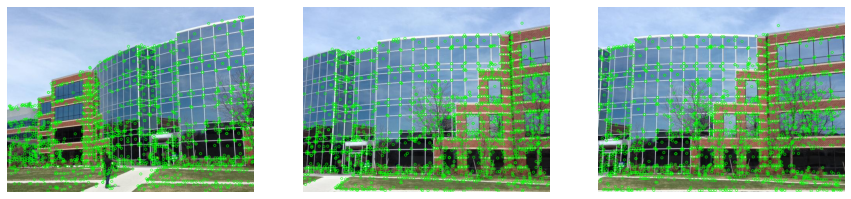

In [19]:
kp_1, desc_1 = get_features(im1)
kp_2, desc_2 = get_features(im2)
kp_3, desc_3 = get_features(im3)

kp_img1 = cv.drawKeypoints(im1, kp_1, None, color=(0,255,0), flags=0)
kp_img2 = cv.drawKeypoints(im2, kp_2, None, color=(0,255,0), flags=0)
kp_img3 = cv.drawKeypoints(im3, kp_3, None, color=(0,255,0), flags=0)

print('keypoints for img1, img2 and img3')
plot_3imgs(kp_img1, kp_img2, kp_img3)

In [20]:
matches12 = match_keypoints(desc_1, desc_2, 0.75)
pts12_1 = np.float32([kp_1[m.queryIdx].pt for m in matches12]).reshape(-1,2)
pts12_2 = np.float32([kp_2[m.trainIdx].pt for m in matches12]).reshape(-1,2)
H12, _ = transform_ransac(pts12_1, pts12_2)

matches32 = match_keypoints(desc_3, desc_2, 0.75)
pts32_1 = np.float32([kp_3[m.queryIdx].pt for m in matches32]).reshape(-1,2)
pts32_2 = np.float32([kp_2[m.trainIdx].pt for m in matches32]).reshape(-1,2)
H32, _ = transform_ransac(pts32_1, pts32_2)

print(H12)
print(H32)

[[ 1.26227891e+00 -9.52889051e-02 -3.15375424e+02]
 [ 1.94759930e-01  1.17036805e+00 -5.76928453e+01]
 [ 4.46269512e-04 -4.78013276e-05  1.00000000e+00]]
[[ 9.08935653e-01  1.34892679e-02  1.03448963e+02]
 [-5.23172524e-02  9.58936654e-01  1.61559177e+01]
 [-1.43127908e-04 -4.43640380e-06  1.00000000e+00]]


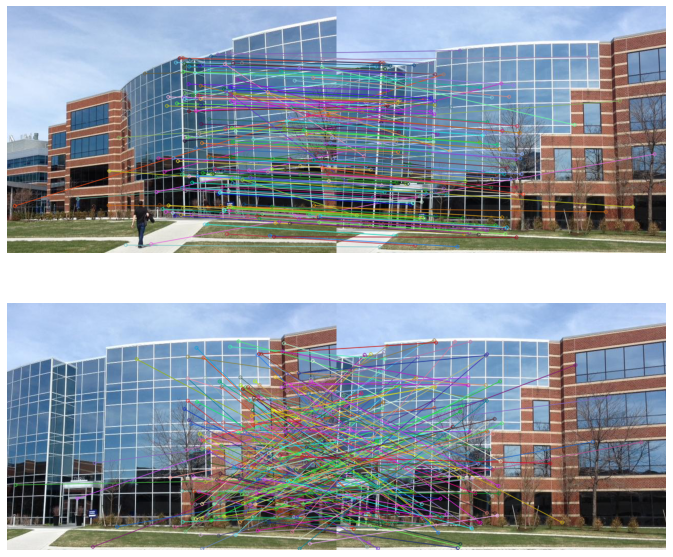

In [21]:
match_plot12 = cv.drawMatches(im1, kp_1, im2, kp_2, matches12[::2], None, flags=2)
match_plot32 = cv.drawMatches(im2, kp_2, im3, kp_3, matches12[::2], None, flags=2)
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
for a in ax:
    a.set_axis_off()
ax[0].imshow(match_plot12)
ax[1].imshow(match_plot32)
plt.show()

In [22]:
tmp = panoramic_stitching(im2, im3)
result2 = panoramic_stitching(im1, tmp)

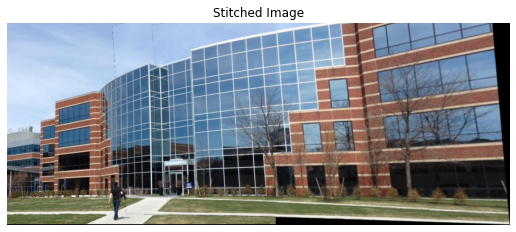

In [23]:
plt.figure(figsize = (9,9))
plt.title("Stitched Image")
plt.axis("off")
plt.imshow(result2.astype('uint8'))
plt.savefig('./imgs/pan3')
plt.show()